## Brain tumor MRI data preprocessing - for segmentation


In [ ]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import keras-cv for focal loss

import keras_cv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 41.1 MB/s eta 0:00:00


In [3]:
# Initialize random seed for reproducibility

import random, numpy as np, tensorflow as tf
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


### Downloading the kaggle dataset

##### The below 3 cells are only for google colab

In [ ]:
# for loading kaggle key

# from google.colab import files
# files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saumya12345","key":"b62855291cca7b61b5f1b1672ed1c8bd"}'}

In [ ]:
# for accessing kaggle key and downloading kaggle dataset

# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d nikhilroxtomar/brain-tumor-segmentation


Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation
License(s): unknown
 99% 308M/312M [00:00<00:00, 517MB/s]
100% 312M/312M [00:00<00:00, 543MB/s]


##### Unzipping the dataset into /content folder

In [7]:
import zipfile

with zipfile.ZipFile('brain-tumor-segmentation.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')


### Initial set-up for utilizing GPU

In [8]:
# Set memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Then initialize strategy
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")


Number of devices: 1


### Data Preparation

#### Converting to numpy array and normalization

In [9]:


# Define paths to image and mask directories
image_dir = "dataset/images"
mask_dir = "dataset/masks"

# List all the PNG files in both directories in sorted order
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))


target_size = (256, 256)

images = []
masks = []

# Load images and masks into numpy arrays
for img_file, mask_file in zip(image_files, mask_files):
    img_path = os.path.join(image_dir, img_file)
    mask_path = os.path.join(mask_dir, mask_file)

    # Open the image and mask and convert to grayscale; resize to target size
    img = Image.open(img_path).convert("L").resize(target_size)  # Default -> bilinear

    # Resize tumor segmentation masks using nearest-neighbor interpolation.
    # This preserves the discrete 0/1 label values without introducing gray pixels
    # at the boundaries (which happens with bilinear interpolation).
    # Nearest-neighbor is the standard practice for resizing binary masks in medical image segmentation.

    mask = Image.open(mask_path).convert("L").resize(target_size, Image.NEAREST)  # Uses nearest neighbor


    # Convert to numpy arrays
    img_array = np.array(img)
    mask_array = np.array(mask)

    # Normalize the images and masks
    img_array = img_array / 255.0
    mask_array = mask_array / 255.0

    # Append to lists
    images.append(img_array)
    masks.append(mask_array)

# Convert the lists to numpy arrays
images = np.array(images)
masks = np.array(masks)

# Print the shapes of the arrays
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)


Images shape: (3064, 256, 256)
Masks shape: (3064, 256, 256)


In [10]:
def check_masks(masks):
  # Checks if all elements in the masks list are either 0 or 1.
  for mask in masks:
    if not np.isin(mask, [0, 1]).all():
      return False
  return True

# Applying the function on masks list obtained
all_0_or_1 = check_masks(masks)

if all_0_or_1:
  print("All mask elements are either 0 or 1")
else:
  print("Some mask elements are not 0 or 1")

All mask elements are either 0 or 1


### Display few examples

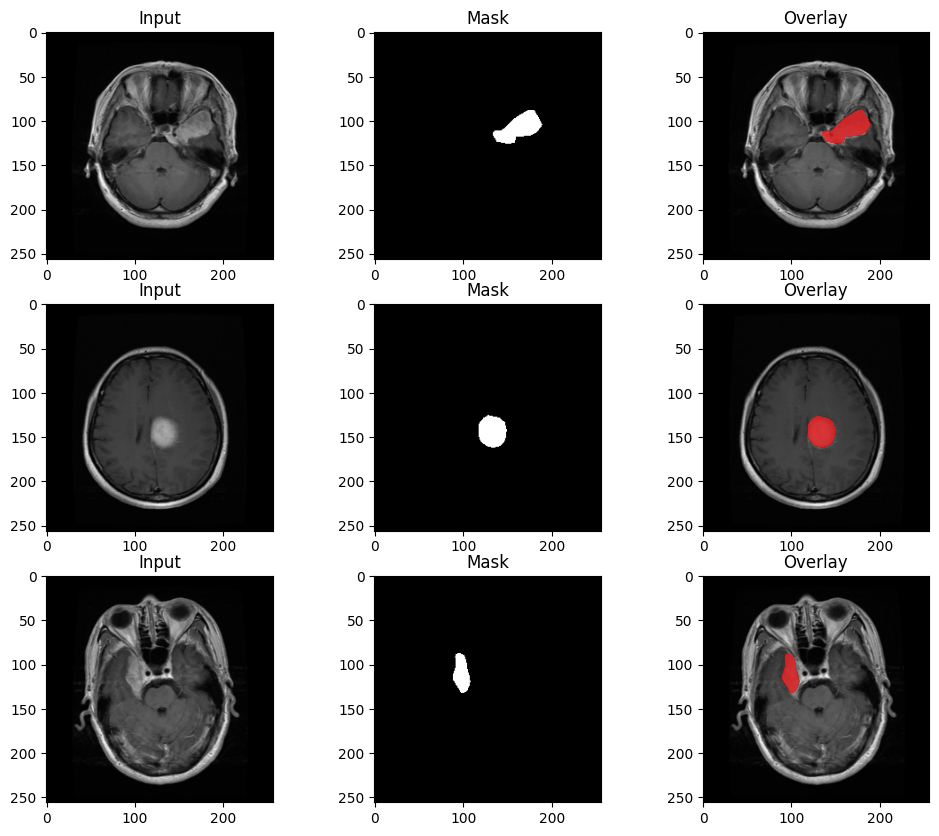

In [11]:

plt.figure(figsize=(12, 10))

plt.subplot(3,3,1)
plt.title('Input')
plt.imshow(images[0,:], cmap = 'gray')

plt.subplot(3,3,2)
plt.title('Mask')
plt.imshow(masks[0,:], cmap = 'gray')

plt.subplot(3,3,3)
plt.title('Overlay')
plt.imshow(images[0,:],cmap='gray')
mask = np.ma.masked_where(masks[0] == False, masks[0])
plt.imshow(mask, alpha=0.8, cmap='Set1')

plt.subplot(3,3,4)
plt.title('Input')
plt.imshow(images[1,:], cmap = 'gray')

plt.subplot(3,3,5)
plt.title('Mask')
plt.imshow(masks[1,:], cmap = 'gray')

plt.subplot(3,3,6)
plt.title('Overlay')
plt.imshow(images[1,:],cmap='gray')
mask = np.ma.masked_where(masks[1] == False, masks[1])
plt.imshow(mask, alpha=0.8, cmap='Set1')

plt.subplot(3,3,7)
plt.title('Input')
plt.imshow(images[2,:], cmap = 'gray')

plt.subplot(3,3,8)
plt.title('Mask')
plt.imshow(masks[2,:], cmap = 'gray')

plt.subplot(3,3,9)
plt.title('Overlay')
plt.imshow(images[2,:],cmap='gray')
mask = np.ma.masked_where(masks[2] == False, masks[2])
plt.imshow(mask, alpha=0.8, cmap='Set1')

#### Split into train, test and validation sets

In [12]:
#from sklearn.model_selection import train_test_split

# Define the split ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# 1. Split into train and test set
X_temp, X_test, mask_temp, mask_test = train_test_split(
        images, masks, test_size=test_ratio, random_state=42
    )

# 2. Split the test set into test and validation set
X_train, X_val, mask_train, mask_val = train_test_split(
        X_temp, mask_temp, test_size=val_ratio / (train_ratio + val_ratio), random_state=42
    )



In [13]:
# delete earlier lists to free up some memory

del images
del masks
del image_files
del mask_files

In [14]:
# Check sizes of train, test and val set

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 1838
Validation set size: 613
Test set size: 613


#### Resizing the data so that channel information is also captured

In [15]:
# Resizing the data so that channel information is also captured
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

mask_train = mask_train.reshape(mask_train.shape[0], mask_train.shape[1], mask_train.shape[2], 1)
mask_test = mask_test.reshape(mask_test.shape[0], mask_test.shape[1], mask_test.shape[2], 1)

X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
mask_val = mask_val.reshape(mask_val.shape[0], mask_val.shape[1], mask_val.shape[2], 1)


# Verifying the shapes
print(X_train.shape)
print(mask_train.shape)
print('\n')
print(X_test.shape)
print(mask_test.shape)
print('\n')
print(X_val.shape)
print(mask_val.shape)

(1838, 256, 256, 1)
(1838, 256, 256, 1)


(613, 256, 256, 1)
(613, 256, 256, 1)


(613, 256, 256, 1)
(613, 256, 256, 1)


In [16]:
# Delete earlier lists to free up memory

del X_temp
del mask_temp

#### Convert to Tensorflow datasets

In [17]:
def preprocess(image, mask):
    image = tf.cast(image, tf.float32)
    mask = tf.cast(mask, tf.float32)
    return image, mask

In [18]:
# Creating a custom Tensorflow dataset

BATCH_SIZE = 8 # Global batch size; each GPU gets 8/n (in case of n GPUs)

with tf.device('/CPU:0'):
    train_data = tf.data.Dataset.from_tensor_slices((X_train, mask_train))
    test_data = tf.data.Dataset.from_tensor_slices((X_test, mask_test))
    val_data = tf.data.Dataset.from_tensor_slices((X_val, mask_val))

    # For training dataset
    train_data = train_data.shuffle(buffer_size=1000, seed=42) # fix seed for reproducability
    train_data = train_data.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) # no augmentation
    train_data = train_data.batch(BATCH_SIZE,drop_remainder=True)

    # for validation dataset
    val_data = val_data.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    val_data = val_data.batch(BATCH_SIZE)

    # for test dataset
    test_data = test_data.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    test_data = test_data.batch(BATCH_SIZE)



In [19]:
# delete earlier lists to free up some memory

del X_train
del mask_train
del X_test
del mask_test
del X_val
del mask_val

#### Visualise few samples to confirm augmentation

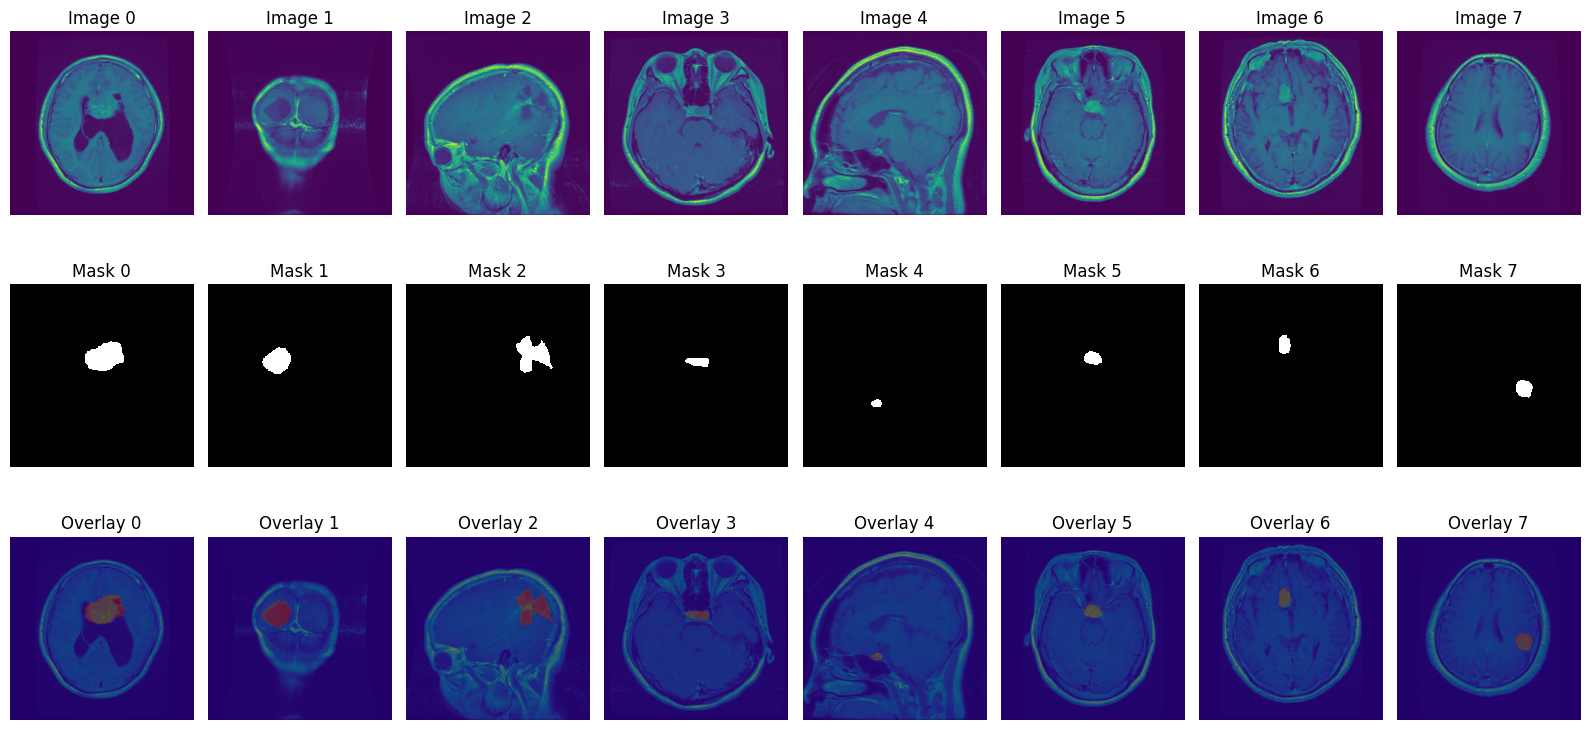

In [20]:

# Take one batch from the dataset
for images, masks in train_data.take(1):
    batch_size = images.shape[0]
    plt.figure(figsize=(16, 8))

    for i in range(batch_size):
        # Show image
        plt.subplot(3, batch_size, i + 1)
        plt.imshow(images[i])
        plt.title(f"Image {i}")
        plt.axis('off')

        # Show corresponding mask
        plt.subplot(3, batch_size, batch_size + i + 1)
        plt.imshow((masks[i]), cmap='gray', interpolation="none")
        plt.title(f"Mask {i}")
        plt.axis('off')

         # Show the overlay of mask on the image
        plt.subplot(3, batch_size, 2 * batch_size + i + 1)
        plt.imshow(images[i])
        # Overlay the mask with transparency (alpha)
        plt.imshow(masks[i], cmap='jet', alpha=0.5, interpolation="none")
        plt.title(f"Overlay {i}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


#### Verifying the tensor data

In [21]:
print("Train shapes:")
for img, mask in train_data.take(1):
    print("Image shape:", img.shape)
    print("Mask shape:", mask.shape)


Train shapes:
Image shape: (8, 256, 256, 1)
Mask shape: (8, 256, 256, 1)


In [22]:
for x, y in train_data.take(1):
    print("y min:", tf.reduce_min(y).numpy())
    print("y max:", tf.reduce_max(y).numpy())
    print("Unique values in y:", tf.unique(tf.reshape(y, [-1]))[0].numpy())


y min: 0.0
y max: 1.0
Unique values in y: [0. 1.]


In [23]:
for img, mask in train_data.take(1):
    print("Image dtype:", img.dtype, "Min:", tf.reduce_min(img).numpy(), "Max:", tf.reduce_max(img).numpy())
    print("Mask dtype:", mask.dtype, "Unique values:", tf.unique(tf.reshape(mask, [-1]))[0].numpy())


Image dtype: <dtype: 'float32'> Min: 0.0 Max: 0.9882353
Mask dtype: <dtype: 'float32'> Unique values: [0. 1.]


In [24]:
for img, mask in train_data:
    if img.shape[0] == 0 or tf.size(mask) == 0:
        print("Empty batch found")


In [25]:
total_pixels = 0
positive_pixels = 0

for _, mask in train_data.take(100):  # sample few batches
    total_pixels += tf.size(mask).numpy()
    positive_pixels += tf.reduce_sum(mask).numpy()

print("Positive pixels percentage:", (positive_pixels / total_pixels) * 100)


Positive pixels percentage: 1.6630096435546873


In [26]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import keras-cv for focal loss

import keras_cv
from tensorflow.keras.metrics import BinaryIoU, Precision, Recall


### Data Loading

### Building and Training the model

In [27]:
from unet import build_unet_model
model = build_unet_model()
model.summary()

[NbConvertApp] WARNING | pattern 'unet.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execut

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ dropout_2[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_3[

 Total params: 34,512,193 (131.65 MB)

 Trainable params: 34,512,193 (131.65 MB)

 Non-trainable params: 0 (0.00 B)

##### For logging hyperparameters

In [28]:
from datetime import datetime
import json

# Define a function to automatically log hyperparameters for each run

def save_run_config(
        model: tf.keras.Model,
        loss_name: str,
        learning_rate:float,
        early_stop_min_delta: float,
        history:tf.keras.callbacks.History,
        epochs_requested:int,
        early_stop_patience:int
):
    run_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"run_config_noaug_{run_time}.json"

    # Computing a simple fingerprint for initial weights
    initial_weight_sum = float(np.sum([np.sum(w.numpy()) for w in model.weights]))

    run_info = {
        "global_batch_size": 8,
        "epochs_requested": epochs_requested,
        "epochs_trained": len(history.epoch),
        "early_stopping_epoch": history.epoch[-1],
        "loss": loss_name,
        "early_stop_min_delta": early_stop_min_delta,
        "learning_rate": learning_rate,
        "early_stop_patience": early_stop_patience,
        "best_val_loss":   float(min(history.history["val_loss"])),
        "best_val_recall":     float(max(history.history["val_recall"])),
        "final_val_loss": float(history.history["val_loss"][-1]),
        "final_val_recall": float(history.history["val_recall"][-1]),
        "best_train_precision": float(max(history.history["precision"])),
        "best_val_precision": float(max(history.history["val_precision"])),

        "initial_weight_sum": initial_weight_sum,
        "timestamp": run_time,
    }

    with open(filename,"w") as f:
        json.dump(run_info, f, indent=4)
        print(f"Saved run config to {filename}")


#### Define Hyperparameters

In [29]:
# Define hyperparameters

LOSS_NAME ="FocalLoss"
LEARNING_RATE=1e-4
EPOCHS = 70
EARLY_STOPPING_PATIENCE = 7
MIN_DELTA = 0.005

#### Model training on GPU

In [30]:
with strategy.scope():

  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_recall",
    mode='max',              # higher is better
    patience=EARLY_STOPPING_PATIENCE,
    min_delta = MIN_DELTA,
    restore_best_weights=True
)
  checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'best_model_flip_{LOSS_NAME}.keras',
    monitor="val_recall",   # same metric
    mode="max",
    save_best_only=True,
    verbose = 1
)

  unet_model = build_unet_model() # Build inside scope


  # Compiling the model within strategy.scope()
  unet_model.compile(loss=keras_cv.losses.FocalLoss(),
                optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
                metrics = ['accuracy',
                Precision(),
                Recall()])


# Training the model
  history = unet_model.fit(
    train_data,epochs = EPOCHS,
    validation_data = val_data,
    callbacks=early_stopping)





Epoch 1/70
229/229 ━━━━━━━━━━━━━━━━━━━━ 166s 653ms/step - accuracy: 0.9464 - loss: 0.0273 - precision: 0.0123 - recall: 0.0300 - val_accuracy: 0.9829 - val_loss: 0.0179 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/70
229/229 ━━━━━━━━━━━━━━━━━━━━ 147s 636ms/step - accuracy: 0.9835 - loss: 0.0065 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9829 - val_loss: 0.0113 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/70
229/229 ━━━━━━━━━━━━━━━━━━━━ 147s 638ms/step - accuracy: 0.9831 - loss: 0.0059 - precision: 0.8687 - recall: 3.6900e-05 - val_accuracy: 0.9830 - val_loss: 0.0082 - val_precision: 0.6452 - val_recall: 0.0116
Epoch 4/70
229/229 ━━━━━━━━━━━━━━━━━━━━ 146s 636ms/step - accuracy: 0.9836 - loss: 0.0048 - precision: 0.8724 - recall: 0.0125 - val_accuracy: 0.9842 - val_loss: 0.0074 - val_precision: 0.6367 - val_recall: 0.1754
Epoch 5/70
229/229 ━━━━━━━━━━━━━━━━━━━━ 146s 636ms/step - accuracy: 0.9855 - loss: 0.0044 - precision: 0.8852 - reca

In [31]:
# Save hyperparameters into log file

save_run_config(
    model=unet_model,
    loss_name=LOSS_NAME,
    learning_rate=LEARNING_RATE,
    early_stop_min_delta= MIN_DELTA,
    history=history,
    epochs_requested=EPOCHS,
    early_stop_patience=EARLY_STOPPING_PATIENCE
  )

Saved run config to run_config_noaug_2025-08-25_08-48-48.json


In [32]:
# Defining a function to extract history from the model and plot and save the metrics as graphs

def show_history(history):
    fig, ax = plt.subplots(1, 3, figsize=(20,5))

    # ---- Loss curves -----

    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')


    # ----- F1 curves ------
    ax[1].set_title('Recall')
    ax[1].plot(history.epoch, history.history["recall"], label="Train recall")
    ax[1].plot(history.epoch, history.history["val_recall"], label="Validation recall")
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Recall')

    ax[2].set_title('Precision')
    ax[2].plot(history.epoch, history.history["precision"], label="Train precision")
    ax[2].plot(history.epoch, history.history["val_precision"], label="Validation precision")
    ax[2].legend()
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('Precision')


    # ---- Saving graph for logging ----

    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename  = f"training_curves_noaug_{timestamp}.png"

    fig.savefig(filename,
                dpi=300, bbox_inches="tight")  # 300 dpi = print‑ready

    # --- Display the plot here ----------
    plt.show()

### Evaluation of model performance

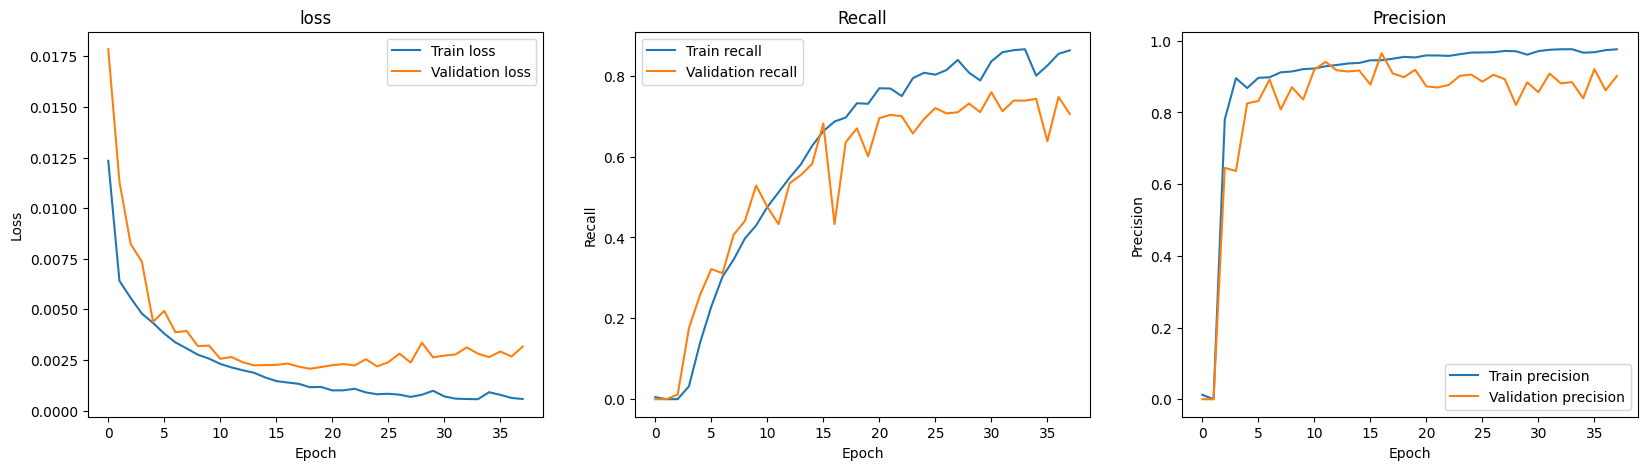

In [33]:
# Plotting the graphs of variation of training metrics over epochs

show_history(history)

In [34]:
# Convert tf.Dataset to normal numpy array for visualisation

# Initialize lists to store images and ground truth masks
all_images = []
all_masks = []

# Iterate through the dataset
for images, masks in test_data:
    all_images.append(images.numpy())  # Convert images to NumPy and adds the batch of images to list
    all_masks.append(masks.numpy())   # Convert masks to NumPy

# Flatten the lists to get all images and masks
all_images = np.concatenate(all_images, axis=0)
all_masks = np.concatenate(all_masks, axis=0)

print(f'Total Images: {all_images.shape}')
print(f'Total Masks: {all_masks.shape}')

Total Images: (613, 256, 256, 1)
Total Masks: (613, 256, 256, 1)


In [35]:

# Evaluate the model on the test dataset and print out the metrics
results = unet_model.evaluate(test_data, return_dict=True)

print(results)
print(f"Test Loss: {results['loss']:.4f}")
print(f"Test Accuracy: {results['accuracy']:.4f}")
print(f"Test Precision: {results['precision']:.4f}")
print(f"Test Recall: {results['recall']:.4f}")

77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 0.9936 - loss: 0.0028 - precision: 0.8492 - recall: 0.7636
{'accuracy': 0.9939790368080139, 'loss': 0.002615718636661768, 'precision': 0.8561530709266663, 'recall': 0.779670238494873}
Test Loss: 0.0026
Test Accuracy: 0.9940
Test Precision: 0.8562
Test Recall: 0.7797


In [36]:


# ---- Obtaining per-image IoU ------------

all_preds = (unet_model.predict(all_images, batch_size=8) > 0.5)

flat_true = all_masks.reshape(all_masks.shape[0], -1).astype(bool)
flat_pred = all_preds.reshape(all_preds.shape[0], -1).astype(bool)

intersection = (flat_true & flat_pred).sum(axis=1)
union = flat_true.sum(axis=1) + flat_pred.sum(axis=1) - intersection

ious = (intersection + 1e-6) / (union + 1e-6) # for each mask

mean_iou = np.mean(ious)
std_iou = np.std(ious)

print(f"Per-image Mean IoU: {mean_iou:.4f} ± {std_iou:.4f}")

77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step
Per-image Mean IoU: 0.6910 ± 0.2635


In [37]:


# ----------- Calculating Precision and Recall ----------------------

y_true = all_masks.astype(np.float32)
y_pred = all_preds.astype(np.float32)

TP = np.sum(y_true * y_pred) #(y_true == 1 and y_pred == 1).sum()
FP = np.sum(y_pred)  - TP    #(y_pred == 1 but y_true == 0).sum()
FN = np.sum(y_true) - TP     #(y_true == 1 but y_pred == 0).sum()

precision = TP / (TP + FP + 1e-6)
recall    = TP / (TP + FN + 1e-6)

print("Pixel level Precision and Recall")
print(f"Global Precision: {precision:.4f}")
print(f"Global Recall   : {recall:.4f}")


Pixel level Precision and Recall
Global Precision: 0.8562
Global Recall   : 0.7797


In [38]:

# Saving evaluation metrics values into json file
results = {
    "Test loss":float(results['loss']),
    "Test accuracy":float(results['accuracy']),
    "Test precision":float(results['precision']),
    "Test recall":float(results['recall']),
    "Computed Mean IoU": float(mean_iou),
    "Computed Std IoU": float(std_iou),
    "Per-image mean IoU":f"{mean_iou:.4f} ± {std_iou:.4f}",
    "Global Precision": float(precision),
    "Global Recall":float(recall),
}

# Save to JSON file with timestamp
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = f"test_results_noaug_{timestamp}.json"

# Dump results to file
with open(filename, "w") as f:
    json.dump(results, f, indent=4)
    print(f"\nSaved test results to {filename}")



Saved test results to test_results_noaug_2025-08-25_08-49-45.json


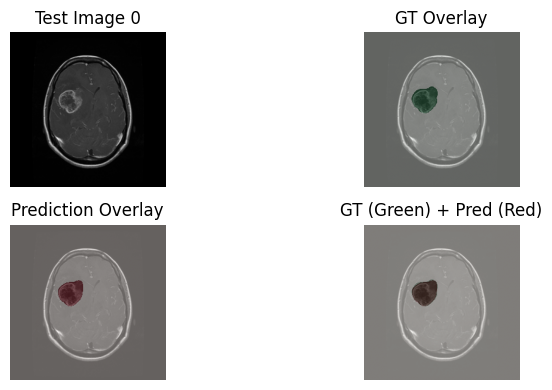

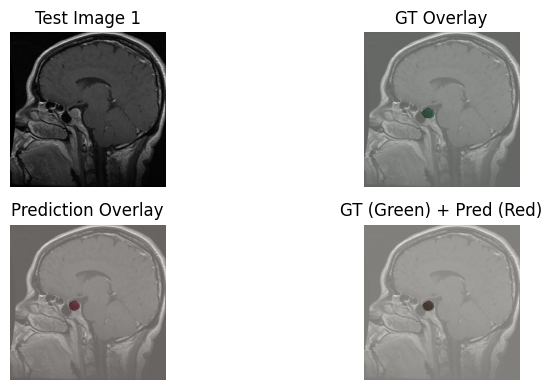

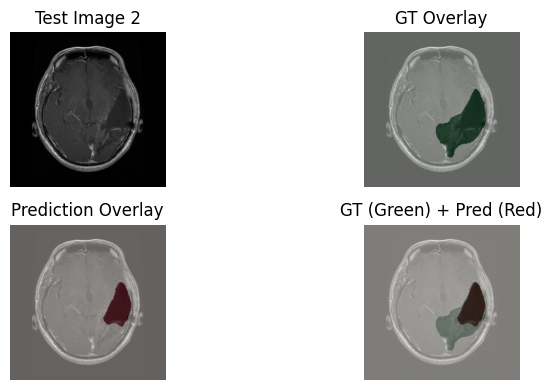

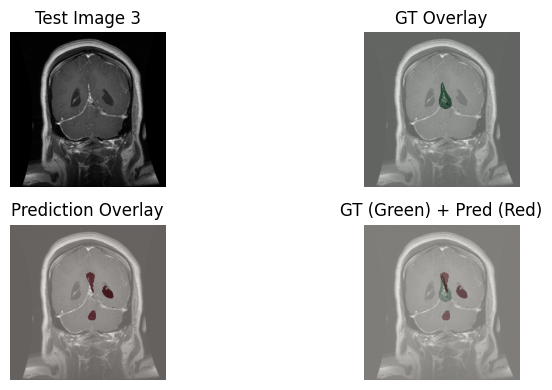

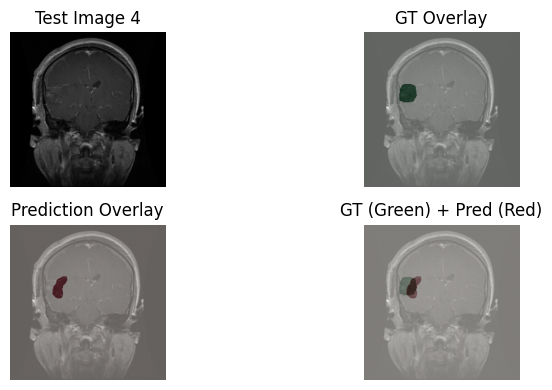

In [39]:

num_samples = 5
for i in range(num_samples):
    plt.figure(figsize=(9, 4))

    # Original image
    plt.subplot(2, 2, 1)
    plt.imshow(all_images[i].squeeze(), cmap='gray')
    plt.title(f"Test Image {i}")
    plt.axis("off")

    # Ground truth overlay
    plt.subplot(2, 2, 2)
    plt.imshow(all_images[i].squeeze(), cmap='gray')
    plt.imshow(all_masks[i].squeeze(), cmap='Greens', alpha=0.4)
    plt.title("GT Overlay")
    plt.axis("off")

    # Prediction overlay
    plt.subplot(2, 2, 3)
    plt.imshow(all_images[i].squeeze(), cmap='gray')
    plt.imshow(all_preds[i].squeeze(), cmap='Reds', alpha=0.4)
    plt.title("Prediction Overlay")
    plt.axis("off")

    # Combined GT + Prediction overlay
    plt.subplot(2, 2, 4)
    plt.imshow(all_images[i].squeeze(), cmap='gray')
    plt.imshow(all_masks[i].squeeze(), cmap='Greens', alpha=0.3)
    plt.imshow(all_preds[i].squeeze(), cmap='Reds', alpha=0.3)
    plt.title("GT (Green) + Pred (Red)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [40]:

unet_model.save_weights(f'final_unet_weights_noaug_{LOSS_NAME}.weights.h5')
print("Weights saved to .h5 file.")


Weights saved to .h5 file.
